In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
import time
import random
import requests

import signaturehelper

In [ ]:
# !pip install requests==2.21.0 

#### - Get Keywords from Naver Searching Advertisement

![](./img/naver-ads.jpg) 

In [28]:
get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID)

{'Content-Type': 'application/json; charset=UTF-8',
 'X-Timestamp': '1612338453856',
 'X-API-KEY': '01000000002c6573aff319a7fb49a48153878c0e3559a4cddf9da1a4e404cb94b9716d9b85',
 'X-Customer': '1930249',
 'X-Signature': b'RyUG4nE9gvuWgv0HR1vbX+DIBoo/MZt9G2y50vxt7rM='}

In [52]:

keydict = {}
with open('./keys.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        keyname = line.split('=')[0]
        key = line.split('=',maxsplit=1)[1].strip()
        keydict[keyname] = key
    

API_KEY = keydict['API_KEY']
SECRET_KEY = keydict['SECRET_KEY']
CUSTOMER_ID = int(keydict['CUSTOMER_ID'])

In [57]:
def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = signaturehelper.Signature.generate(timestamp, method, uri, SECRET_KEY)
    return {
            'Content-Type': 'application/json; charset=UTF-8',
            'X-Timestamp': timestamp,
            'X-API-KEY': API_KEY,
            'X-Customer': str(CUSTOMER_ID), 
            'X-Signature': signature
           }

BASE_URL = 'https://api.naver.com'


# API_KEY='01000000002c6573aff319a7fb49a48153878c0e3559a4cddf9da1a4e404cb94b9716d9b85'
# SECRET_KEY='AQAAAAAsZXOv8xmn+0mkgVOHjA41adczLrAq2j84OKjr0N/NNA=='
# CUSTOMER_ID=1930249
uri = '/keywordstool'
method = 'GET'
payload={
        'hintKeywords':'쌍화차',
        'showDetail' :1
        }

r = requests.get(BASE_URL + uri, params=payload, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))
# json = payload #if you use 

# print("response status_code = {}".format(r.status_code) )
# print("response body = {}".format(r.json() )  )

keywords = r.json()['keywordList'][:100]

del r

#### response json Structure
{'keyswordList':  [{...},{...},, .    ]  }   
{
    "relKeyword": "쌍화탕",
    "monthlyPcQcCnt": ">10",
    "monthlyMobileQcCnt": ">10",
    "monthlyAvePcClkCnt": ">10",
    "monthlyAveMobileClkCnt": ">10",
    "monthlyAvePcCtr": ">10",
    "monthlyAveMobileCtr": ">10",
    "plAvgDepth": ">10",
    "compIdx": "high"
}

In [65]:
keywords = pd.DataFrame(keywords)

In [70]:
pd.set_option('display.max_rows',200)

- 월간 검색수 : 네이버를 이용한 사용자가 PC 및 모바일 에서 해당 키워드를 검색한 횟수
- 월평균 클릭수 : 최근 한 달 간 사용자가 해당 키워드를 검색했을 때, 통합검색 영역에 노출된 광고가 받은 평균 클릭수 입니다 
- 월평균 클릭률 
- 경쟁 정도 : 높음 / 중간 / 낮음


In [80]:
keywords.columns = ['relkeyword','sch','mob_sch','click','mob_click','clk_r','mob_clk_r','num_ads','comp']

comp_dic={'높음':2,'중간':1,'낮음':0}

keywords.comp = keywords.comp.apply(lambda x : comp_dic[x])
keywords.sch = keywords.sch.astype('str').str.replace('< ','').astype('int')
keywords.mob_sch = keywords.mob_sch.astype('str').str.replace('< ','').astype('int')

In [136]:
keywords.to_csv('relkeyword.csv')

In [121]:
# example of filter
def get_harmony(x,y):
    return 2/ ( (1/x)+(1/y) )

def get_hotkeyword(keywords):
    sch_harmony = get_harmony(keywords.sch,keywords.mob_sch)
    sch_q6 = sch_harmony.quantile(q=0.6)
    
    clkr_harmony = get_harmony(keywords.clk_r,keywords.mob_clk_r)
    clkr_q6 = clkr_harmony.quantile(q=0.6)
    return keywords[ (sch_harmony>sch_q6) & (clkr_harmony>clkr_q6) ]

In [150]:
# save data
keywords.to_csv('data/keywords.csv')
import pickle
with open('data/keywords.pkl','wb') as f:
    pickle.dump(keywords,f)

#### - Get graph from Naver DataLab 

![](./img/datalab.png) 

In [153]:
# standard sample provided by Naver Developers site
#-*- coding: utf-8 -*-
import os
import sys
import urllib.request
client_id = "mPqve99kz5A07ptbK3BE"
client_secret = "zfhC0sLs8M"
url = "https://openapi.naver.com/v1/datalab/search";
body = "{\"startDate\":\"2017-01-01\",\"endDate\":\"2017-04-30\",\"timeUnit\":\"month\",\"keywordGroups\":[{\"groupName\":\"한글\",\"keywords\":[\"한글\",\"korean\"]},{\"groupName\":\"영어\",\"keywords\":[\"영어\",\"english\"]}],\"device\":\"pc\",\"ages\":[\"1\",\"2\"],\"gender\":\"f\"}";

request = urllib.request.Request(url)
request.add_header("X-Naver-Client-Id",client_id)
request.add_header("X-Naver-Client-Secret",client_secret)
request.add_header("Content-Type","application/json")
response = urllib.request.urlopen(request, data=body.encode("utf-8"))
rescode = response.getcode()
if(rescode==200):
    response_body = response.read()
    print(response_body.decode('utf-8'))
else:
    print("Error Code:" + rescode)

{"startDate":"2017-01-01","endDate":"2017-04-30","timeUnit":"month","results":[{"title":"한글","keywords":["한글","korean"],"data":[{"period":"2017-01-01","ratio":47.00101},{"period":"2017-02-01","ratio":53.23619},{"period":"2017-03-01","ratio":100},{"period":"2017-04-01","ratio":85.327}]},{"title":"영어","keywords":["영어","english"],"data":[{"period":"2017-01-01","ratio":40.0881},{"period":"2017-02-01","ratio":36.69942},{"period":"2017-03-01","ratio":52.11792},{"period":"2017-04-01","ratio":44.4595}]}]}


In [ ]:
# changed to requests library #😁 i'm comfortable of this

In [169]:
client_id = "mPqve99kz5A07ptbK3BE"
client_secret = "zfhC0sLs8M"
url = "https://openapi.naver.com/v1/datalab/search";
body = {
    'startDate': '2017-01-01',
    'endDate': '2017-04-30',
    'timeUnit': 'month',
    'keywordGroups': [{'groupName': '한글', 'keywords': ['한글', 'korean']},
                      {'groupName': '영어', 'keywords': ['영어', 'english']}],
    'device': 'pc',
    'ages': ['1', '2'],
    'gender': 'f'
}

header = {}
header["X-Naver-Client-Id"] = client_id
header["X-Naver-Client-Secret"] = client_secret
header["Content-Type"]="application/json"
rq = requests.post(url ,json=body0 ,headers=header )


In [171]:
rq.status_code
rq.json()

In [175]:
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)

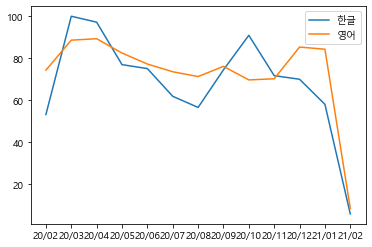

In [222]:
for item in rq.json()['results']:
    x=[]
    y=[]
    for day in item['data']:
        x.append(day['period'].split('-')[0][2:]+'/'+day['period'].split('-')[1])
        y.append(day['ratio'])
    plt.plot(x,y,label=item['title'])
plt.legend(loc='best')
plt.show()


### - Integrate Ads Keywords & DataLab to one System 

![](img/crowd.png)

In [319]:
# Korean font for matplotlib graph 
from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
# Get keys from keys.txt file
keydict = {}
with open('./keys.txt','r') as f:
    lines = f.readlines()
    for line in lines:
        keyname = line.split('=')[0]
        key = line.split('=',maxsplit=1)[1].strip()
        keydict[keyname] = key
    

API_KEY = keydict['API_KEY']
SECRET_KEY = keydict['SECRET_KEY']
CUSTOMER_ID = int(keydict['CUSTOMER_ID'])

In [320]:
kwd = '쌍화차'

## naver ads keywords
def get_header(method, uri, api_key, secret_key, customer_id):
    timestamp = str(round(time.time() * 1000))
    signature = signaturehelper.Signature.generate(timestamp, method, uri, SECRET_KEY)
    return {
            'Content-Type': 'application/json; charset=UTF-8',
            'X-Timestamp': timestamp,
            'X-API-KEY': API_KEY,
            'X-Customer': str(CUSTOMER_ID), 
            'X-Signature': signature
           }

BASE_URL = 'https://api.naver.com'

uri = '/keywordstool'
method = 'GET'
payload={
        'hintKeywords':kwd,
        'showDetail' :1
        }

r = requests.get(BASE_URL + uri, params=payload, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))
# json = payload #if you use 

# print("response status_code = {}".format(r.status_code) )
# print("response body = {}".format(r.json() )  )

keywords = r.json()['keywordList'][:100]

del r

In [324]:
keywords = pd.DataFrame(keywords)

# preprocessing
keywords.columns = ['relkeyword','sch','mob_sch','click','mob_click','clk_r','mob_clk_r','num_ads','comp']

comp_dic={'높음':2,'중간':1,'낮음':0}

keywords.comp = keywords.comp.apply(lambda x : comp_dic[x])
keywords.sch = keywords.sch.astype('str').str.replace('< ','').astype('int')
keywords.mob_sch = keywords.mob_sch.astype('str').str.replace('< ','').astype('int')

In [325]:
keywords10 = keywords[:10]

In [327]:
from datetime import datetime
from dateutil.relativedelta import relativedelta as delta
end = datetime.now().strftime('%Y-%m-%d')
start   = (datetime.now() - delta(years=1) ).strftime('%Y-%m-%d')

kwds=keywords10.relkeyword.to_list()

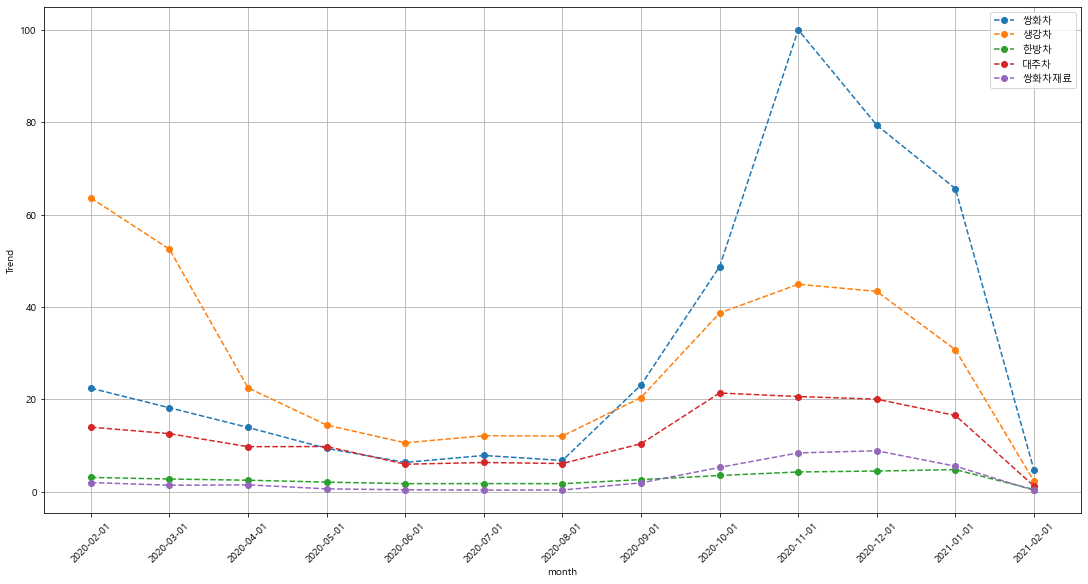

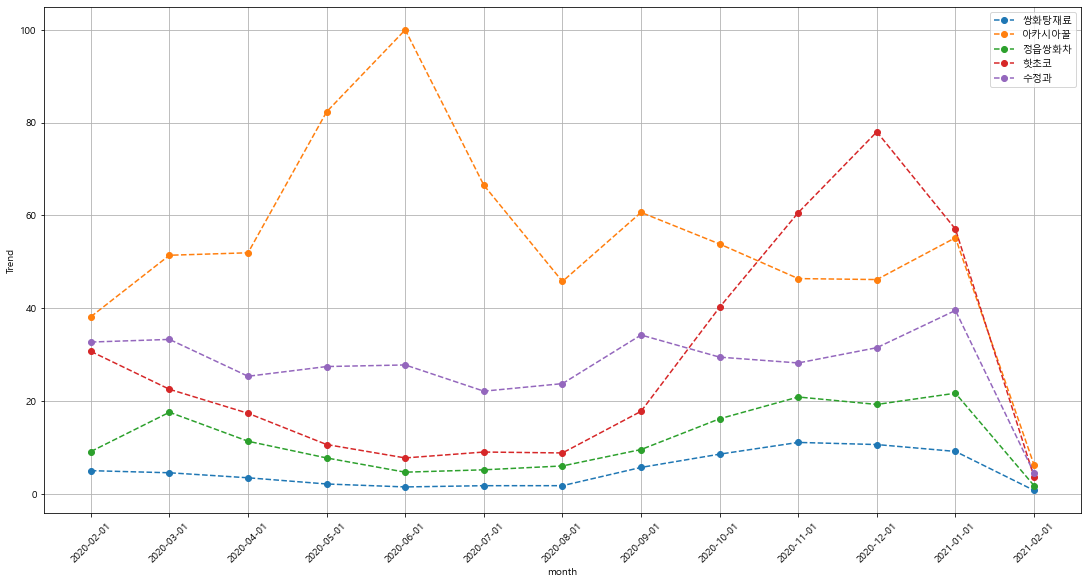

In [357]:
###### have to iterate with that below this
kwd01 = []
kwd01.append(kwds[:5])
kwd01.append(kwds[5:])

## naver data lab

for i in range(2):
    client_id = keydict['nav_client_id']
    client_secret = keydict['nav_client_secret']
    url = "https://openapi.naver.com/v1/datalab/search";
    body = {
        'startDate': start,
        'endDate':  end,
        'timeUnit': 'month',
        'keywordGroups' :[]
    #     'keywordGroups': [{'groupName': '한글', 'keywords': ['한글', 'korean']},
    #                       {'groupName': '영어', 'keywords': ['영어', 'english']}],
    #     'device': 'pc',
    #     'ages': ['1', '2'],
    #     'gender': 'f'
    }
    for kw in kwd01[i]:
        group = { 'groupName': kw , 'keywords': [kw] }
        body['keywordGroups'].append(group)

    header = {}
    header["X-Naver-Client-Id"] = client_id
    header["X-Naver-Client-Secret"] = client_secret
    header["Content-Type"]="application/json"
    rq = requests.post(url ,json=body ,headers=header )

    results = rq.json()['results']

    fig, axs = plt.subplots(1, 1, constrained_layout=True, sharey=True,figsize=(15,8))
    for item in results:
        df = pd.DataFrame(item['data'])
        axs.plot(df.period,df.ratio,'--o',label=item['title'])

    axs.grid(True)  
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.xlabel('month')
    plt.ylabel('Trend')
    fig.savefig('data/graph%d.png'%(i))
# plt.title('jax')

In [359]:
for i in range(2):
    os.remove('data/graph%d.png'%(i))

### never mind 🔽

##### Guide of Naver ads keywords API 

In [ ]:
# BusinessChannel Usage Sample

uri = '/ncc/channels'
method = 'GET'
r = requests.get(BASE_URL + uri, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))


# Adgroup Usage Sample

# 1. GET adgroup Usage Sample

uri = '/ncc/adgroups'
method = 'GET'
r = requests.get(BASE_URL + uri, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))
target_adgroup = r.json()[0]

# 2. CREATE adgroup Usage Sample

uri = '/ncc/adgroups'
method = 'POST'
payload = {'name': 'TEST#' + str(random.randrange(1000, 9999)), 'nccCampaignId' : target_adgroup['nccCampaignId'], 'pcChannelId' : target_adgroup['pcChannelId'], 'mobileChannelId': target_adgroup['mobileChannelId']}
r = requests.post(BASE_URL + uri, json=payload, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

created_adgroup = r.json()

# 3. UPDATE Adgroup Usage Sample

uri = '/ncc/adgroups/' + created_adgroup['nccAdgroupId']
method = 'PUT'
created_adgroup['userLock'] = 0
r = requests.put(BASE_URL + uri, params={'fields': 'userLock'}, json=created_adgroup, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

# 4. DELETE Adgroup

uri = '/ncc/adgroups/' + created_adgroup['nccAdgroupId']
method = 'DELETE'
r = requests.delete(BASE_URL + uri, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.content))

# AdKeyword Usage Sample

# 1. CREATE AdKeyword

uri = '/ncc/keywords'
method = 'POST'
r = requests.post(BASE_URL + uri, params={'nccAdgroupId': created_adgroup['nccAdgroupId']}, json=[{'keyword': 'hello'}], headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

created_adkeyword = r.json()[0]

# 2. GET AdKeyword

uri = '/ncc/keywords'
method = 'GET'
r = requests.get(BASE_URL + uri, params={'nccAdgroupId': created_adgroup['nccAdgroupId']}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

# 3. UPDATE AdKeyword

uri = '/ncc/keywords'
method = 'PUT'
created_adkeyword['userLock'] = 0
r = requests.put(BASE_URL + uri, params={'fields': 'userLock'}, json=[created_adkeyword], headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))


# 4. GET and UPDATE AdKeyword (BidAmt)

uri = '/ncc/keywords/' + created_adkeyword['nccKeywordId']
method = 'GET'
r = requests.get(BASE_URL + uri, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

retrieved_adkeyword = r.json()

uri = '/ncc/keywords'
method = 'PUT'
retrieved_adkeyword['bidAmt'] = 300
retrieved_adkeyword['useGroupBidAmt'] = 0
r = requests.put(BASE_URL + uri, params={'fields': 'bidAmt'}, json=[retrieved_adkeyword], headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))


# 5. DELETE AdKeyword

uri = '/ncc/keywords/' + created_adkeyword['nccKeywordId']
method = 'DELETE'
r = requests.delete(BASE_URL + uri, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.content))


# Estimate Usage Sample

# 1. average-position-bid

uri = '/estimate/average-position-bid/keyword'
method = 'POST'
r = requests.post(BASE_URL + uri, json={'device': 'PC', 'items': [{'key': '제주여행', 'position': 1}, {'key': '게스트하우스', 'position': 2}, {'key': '자전거여행', 'position': 3}]}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("#response status_code = {}".format(r.status_code))
print("#response body = {}".format(r.json()))


# 2. exposure-minimum-bid

uri = '/estimate/exposure-minimum-bid/keyword'
method = 'POST'
r = requests.post(BASE_URL + uri, json={'device': 'PC', 'period': 'MONTH', 'items': ['제주여행', '게시트하우스', '자전거여행']}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

# 3. median-bid

uri = '/estimate/median-bid/keyword'
method = 'POST'
r = requests.post(BASE_URL + uri, json={'device': 'PC', 'period': 'MONTH', 'items': ['제주여행', '게시트하우스', '자전거여행']}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))


# 4. performance

uri = '/estimate/performance/keyword'
method = 'POST'
r = requests.post(BASE_URL + uri, json={'device': 'PC', 'keywordplus': True, 'key': '중고차', 'bids': [100, 500, 1000, 1500, 2000, 3000, 5000]}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

# 5. performance-bulk

uri = '/estimate/performance-bulk'
method = 'POST'
r = requests.post(BASE_URL + uri, json={'items': [{'device': 'PC', 'keywordplus': True, 'keyword': '제주여행', 'bid': 70}, {'device': 'PC', 'keywordplus': True, 'keyword': '제주도', 'bid': 80}, {'device': 'PC', 'keywordplus': True, 'keyword': '제주도맛집', 'bid': 90}, ]}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))

# Stat Usage Sample

# 1. GET Summary Report per multiple entities 

uri = '/stats'
method = 'GET'
stat_ids = [target_adgroup['nccCampaignId'], target_adgroup['nccAdgroupId']]
r = requests.get(BASE_URL + uri, params={'ids': stat_ids, 'fields': '["clkCnt","impCnt","salesAmt", "ctr", "cpc", "avgRnk", "ccnt"]', 'timeRange': '{"since":"2019-06-01","until":"2019-06-25"}'}, headers=get_header(method, uri, API_KEY, SECRET_KEY, CUSTOMER_ID))

print("response status_code = {}".format(r.status_code))
print("response body = {}".format(r.json()))